## Ilinois Basin data preliminary analysis

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_preparation import Catalogue
from tqdm import tqdm
import os
import pickle
from clustering_module import ScipyHierarchy, EvaluateClustering
import plotting_geo
import seaborn as sns


In [5]:
cluster_labels = pd.read_csv('../data/the_geysers/cluster_labels', index_col = 0)

In [15]:
np.shape([item for item in cluster_labels.values.T[0]])

(5254,)

### Data analysis

In [2]:
raw_catalogue = pd.read_excel(r'../data/illinois_basin/data/DD_relocations_catalogue_20200428_regionletters_95pcnt_confidence.xlsx', sheet_name='Local_crs_metres', index_col=[0])

The 'latitude' 'longitude' are in reality relative northing/easting positions

In [3]:
reduced_catalogue = raw_catalogue[['SLB origin time', 'SLB northing (m)', 'SLB easting (m)', 'SLB depth (m)', 'SLB magnitude (Mw)']].copy()
reduced_catalogue = reduced_catalogue.rename(columns={'SLB origin time':'event_time', 'SLB northing (m)':'Latitude', 'SLB easting (m)': 'Longitude', 'SLB depth (m)': 'Depthkm', 'SLB magnitude (Mw)':'magnitude'})
reduced_catalogue.head()

,event_time,Latitude,Longitude,Depthkm,magnitude
NORSAR_ID,,,,,
2636,2012-10-07 21:42:31.324,1613.611,-1833.372,2213.762,-0.34
2647,2012-10-09 05:30:48.846,1621.536,-1820.875,2207.971,-0.54
3921,2013-09-15 23:05:32.826,1600.505,-1835.201,2194.560,0.13
2664,2012-10-10 14:34:42.771,1585.265,-1848.612,2208.276,-0.67
3911,2013-09-15 19:55:27.488,1581.912,-1842.211,2201.875,0.25


In [4]:
print(reduced_catalogue.event_time.min(), reduced_catalogue.event_time.max())

2011-12-15 00:57:20.746000 2018-07-02 00:39:13.613000


In [5]:
print(f'Latitude: {reduced_catalogue.Latitude.min()} to {reduced_catalogue.Latitude.max()}')
print(f'Longitude: {reduced_catalogue.Longitude.min()} to {reduced_catalogue.Longitude.max()}')
print(f'Depth: {reduced_catalogue.Depthkm.min()} to {reduced_catalogue.Depthkm.max()}')

Latitude: -893.064 to 2214.982
Longitude: -2252.472 to 1204.57
Depth: 1834.896 to 2271.065


In [6]:
geo_bounds = {'lat_min': -2000,
            'lat_max': 2000,
            'long_min': -2000,
            'long_max': 2000,
            'depth_min': 1500,
            'depth_max': 2500,
            'step_l': 200,
            'step_d': 50}

In [7]:
data_catalogue = Catalogue(catalogue = reduced_catalogue, geo_bounds=geo_bounds)
data_catalogue.index_cubes()

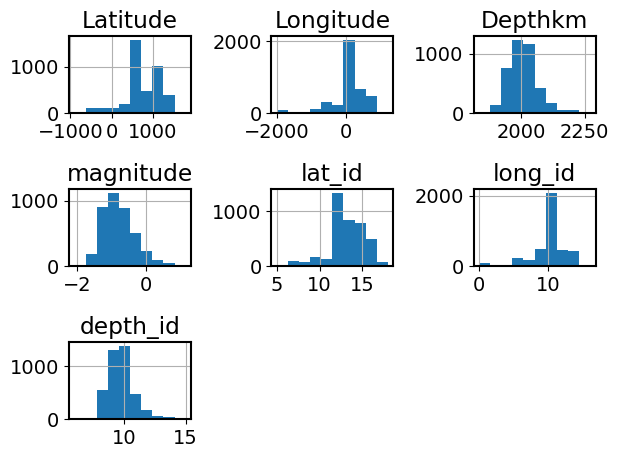

In [8]:
data_catalogue.reduced_catalogue[['Latitude', 'Longitude', 'Depthkm', 'magnitude', 'lat_id', 'long_id', 'depth_id']].hist()
plt.tight_layout()

### Time series and distance matrix preparation

In [9]:
def index_1d(row:pd.Series, max_lat:int, max_long:int) -> int:
    #Retrun index
    return int(row['lat_id'] + max_lat * row['long_id'] + max_lat * max_long * row['depth_id'])

- df_density

In [10]:
start_date = data_catalogue.reduced_catalogue.event_time.min()

data_catalogue.reduced_catalogue['day_id'] = reduced_catalogue.apply(lambda row: int((row.event_time-start_date).days // 3), axis=1)
df_density = data_catalogue.compile_dataset_days()

- time_series and df_density loop for different values of time_range (now commented as the results are saved)

In [11]:
# distance_matrices = []
# time_ranges = [10, 30]

# for t, time_range in enumerate(time_ranges):
#     start_date = data_catalogue.reduced_catalogue.event_time.min()
#     data_catalogue.reduced_catalogue['year'] = reduced_catalogue.apply(lambda row: row.event_time.year, axis=1)
#     data_catalogue.reduced_catalogue['month'] = reduced_catalogue.apply(lambda row: row.event_time.month, axis=1)
#     data_catalogue.reduced_catalogue['day_id'] = reduced_catalogue.apply(lambda row: int((row.event_time-start_date).days // time_range), axis=1)

#     df_density = data_catalogue.compile_dataset_days()

#     lat_max = len(data_catalogue.lat_range)
#     long_max = len(data_catalogue.long_range)

#     df_density['index_1D'] = df_density.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)

#     # preallocation of results - in the output array each row corresponds to one cube, and each columt to one month
#     result = np.zeros((len(data_catalogue.lat_range)*len(data_catalogue.long_range)*len(data_catalogue.depth_range), df_density['period'].max()))

#     print(f"Time series: ")
#     for i, index in tqdm(enumerate(df_density['index_1D'].unique())):

    
#         selected_data = df_density[df_density['index_1D'] == index]

#         for ii in range(df_density['period'].max()):

#             if selected_data[selected_data['period'] == ii].empty:
#                 continue
#             else:
#                 month_data = selected_data[selected_data['period'] == ii]
#                 result[index, ii] = month_data.iloc[0, 3]

#     data_catalogue.time_series_array = result.astype('int32')

#     if distance_matrices is None:
#         distance_matrices = data_catalogue.distance_matrix()
#     else:
#         distance_matrices.append(data_catalogue.distance_matrix())
    
#     np.savetxt(f'ditance_matrix_{time_range}.txt', distance_matrices[t])
#     np.savetxt(f'time_series_{time_range}.txt', result.astype('int32'))

### Old plots

Plot them on the same graph

In [12]:
# plt.figure(figsize=(12,8))
# for index in (df_density['index_1D'].unique()):
#     plt.plot(time_series[index, :], alpha=0.5)

In [13]:
# X_mesh, Y_mesh = np.meshgrid(data_catalogue.long_range[:-1], data_catalogue.lat_range[:-1])
# hist, x_edges, y_edges = np.histogram2d(data_catalogue.reduced_catalogue['Longitude'], data_catalogue.reduced_catalogue['Latitude'], bins=(data_catalogue.long_range, data_catalogue.lat_range))

# plt.contourf(X_mesh, Y_mesh, np.log10(hist), cmap='jet', vmin=0, vmax=3)
# plt.colorbar()
# plt.show()

# x_range, y_range = range(len(data_catalogue.long_range)), range(len(data_catalogue.lat_range))
# X_mesh, Y_mesh = np.meshgrid(x_range[:-1], y_range[:-1])

# hist, x_edges, y_edges = np.histogram2d(df_density['long_id'], df_density['lat_id'], bins=(x_range, y_range))

# plt.contourf(X_mesh, Y_mesh, hist, cmap='jet', vmin=0)
# plt.colorbar()
# plt.show()

### Clustering evaluation and eq-based time series clustering

1. Start with 4 configs - 3h, 12h, 24h, 72h
2. Clustering based on DTH
3. Check the silhouette coefficient to determine the no clusters and which config is better
4. Try to retrieve information on the injections and well positions (either the website or the paper)

Load distance matrices and time series

In [14]:
# Load distance matrices
distance_matrices = {}
keys = ['72h', '24h', '12h', '3h']
file_path = r'..\data\illinois_basin\clustering_evaluation\distance_matrix'

for i, file_name in enumerate(os.listdir(file_path)):

    with open(os.path.join(file_path, file_name), 'rb') as dm :
        distance_matrices[keys[i]] = pickle.load(dm)


# Load time series
time_series = {}
keys = ['72h', '24h', '12h', '3h']
file_path = r'..\data\illinois_basin\clustering_evaluation\time_series'

for i, file_name in enumerate(os.listdir(file_path)):

    with open(os.path.join(file_path, file_name), 'rb') as dm :
        time_series[keys[i]] = pickle.load(dm)

Extract eq-nodes

In [15]:
all_nodes = np.arange(len(time_series[keys[0]]))
eq_nodes = all_nodes[np.sum(time_series[keys[0]], axis=1) > 0]

Extract time series of eq-nodes

In [16]:
time_series_eq_nodes = {}

for key, time_series_array in time_series.items():
    time_series_eq_nodes[key] = time_series_array[eq_nodes]

Produce distance matrix of eq-nodes

In [17]:
distance_matrices_eq_nodes = {}

for key, time_series_array in time_series_eq_nodes.items():

    data_catalogue.time_series_array = time_series_array
    distance_matrices_eq_nodes[key] = data_catalogue.distance_matrix()

100%|██████████| 322/322 [00:01<00:00, 233.41it/s]


Evaluate clustering - search grid

In [18]:
# search_params = {'threshold' : np.arange(2, 15, 1),
#                  'method': ['ward', 'average', 'single', 'complete'],
#                  'reduce': [False]}

# clustering_scores = {}

# for i, key in enumerate(distance_matrices_eq_nodes):
    
#     eval = EvaluateClustering(ScipyHierarchy, np.triu(distance_matrices_eq_nodes[key]))
#     clustering_scores[key] = eval.grid_search_clustering(search_params)

#     # Save results to csv
#     # clustering_scores[key].to_csv(f'clustering_scores_eq_nodes_{key}.csv')

    

Perform clustering with the best results

In [19]:
# df_catalogue = data_catalogue.reduced_catalogue
# lat_max = len(data_catalogue.lat_range)
# long_max = len(data_catalogue.long_range)

# df_catalogue['index_1D'] = df_catalogue.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)
# cluster_labels = np.zeros(len(all_nodes))
# cluster_labels[eq_nodes] = clustering.labels_
# df_cluster_labels = pd.DataFrame(data=cluster_labels, columns=['cluster'])

# df_catalogue = df_catalogue.merge(df_cluster_labels, left_on='index_1D', right_index=True)

In [20]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform

Z = linkage(np.triu(squareform(pdist(time_series_eq_nodes['72h'], metric = 'euclidean'))), method = 'ward')

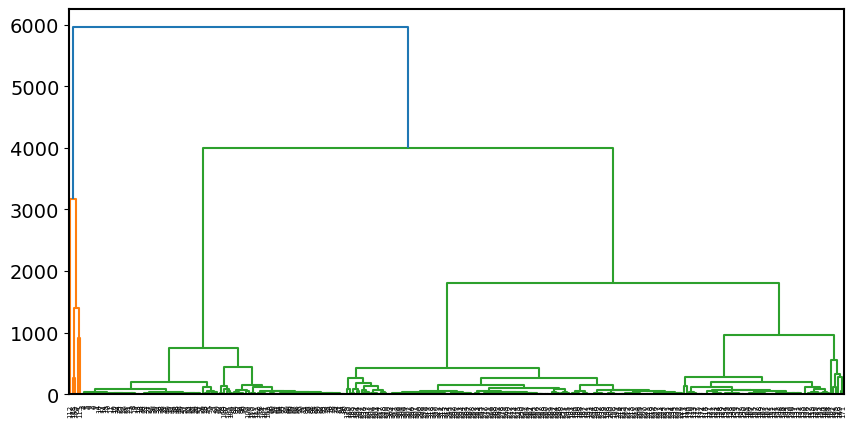

In [21]:
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
cluster_label_test = fcluster(Z, t = 5, criterion='maxclust')

4


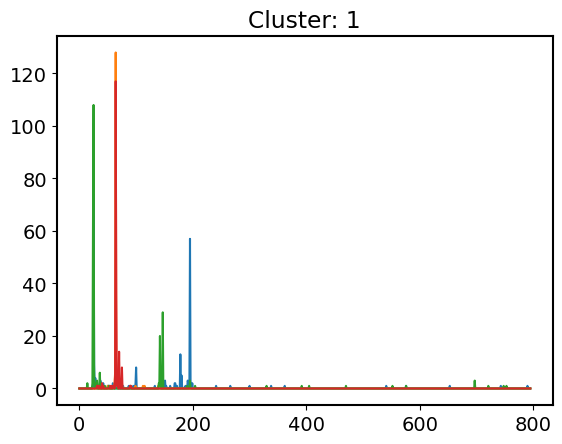

In [22]:
plotted_cluster = 1
print(np.sum(cluster_label_test==plotted_cluster))

for series in time_series_eq_nodes['72h'][cluster_label_test==plotted_cluster]:
    plt.plot(np.arange(len(time_series_eq_nodes['72h'][0])), series)
    plt.title(f'Cluster: {plotted_cluster}')
plt.show()

In [23]:
print(np.sum(cluster_label_test==1))

4


- Add cluster column to df_catalogue

In [24]:
df_catalogue = data_catalogue.reduced_catalogue
lat_max = len(data_catalogue.lat_range)
long_max = len(data_catalogue.long_range)

df_catalogue['index_1D'] = df_catalogue.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)
cluster_labels = np.zeros(len(all_nodes))
cluster_labels[eq_nodes] = cluster_label_test
df_cluster_labels = pd.DataFrame(data=cluster_labels, columns=['cluster'])

df_catalogue = df_catalogue.merge(df_cluster_labels, left_on='index_1D', right_index=True)

In [25]:
len(cluster_label_test)

322

In [26]:
np.sum(cluster_labels > 0)

322

In [27]:
np.sum(eq_nodes == 4984)

0

In [28]:
df_catalogue['index_1D'].max()

6736

- Add 'lat', 'long', 'depth' columns ot df_denstiy

In [29]:
df_density['lat'] = data_catalogue.lat_range[df_density.loc[:, 'lat_id'].values]
df_density['long'] = data_catalogue.long_range[df_density.loc[:, 'long_id'].values]
df_density['depth'] = data_catalogue.depth_range[df_density.loc[:, 'depth_id'].values]

df_catalogue = df_catalogue.rename(columns={'Depthkm' : 'Depth'})

c:\Users\macie\OneDrive\Pulpit\Fellowship\The Geysers\code\the_geysers\plotting_geo.py:223: RuntimeWarning: divide by zero encountered in log10
  axes[0, i].contour(X_cat[:-1, :-1]+(geo_bounds['step_l']/2), Y_cat[:-1, :-1]+(geo_bounds['step_l']/2), np.log10(H_cat.T), 15, cmap='Greys', alpha = 0.5)
20:43:57 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\macie\OneDrive\Pulpit\Fellowship\The Geysers\code\the_geysers\plotting_geo.py:239: RuntimeWarning: divide by zero encountered in log10
  axes[1, i].contour(X_cat_depth[:-1, :-1]+(geo_bounds['step_l']/2), Z_cat_depth[:-1, :-1]+(geo_bounds['step_d']/2), np.log10(H_cat_depth.T), 15,
20:43:57 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
20:43:57 WARNING No artists with labels found to put in legend.

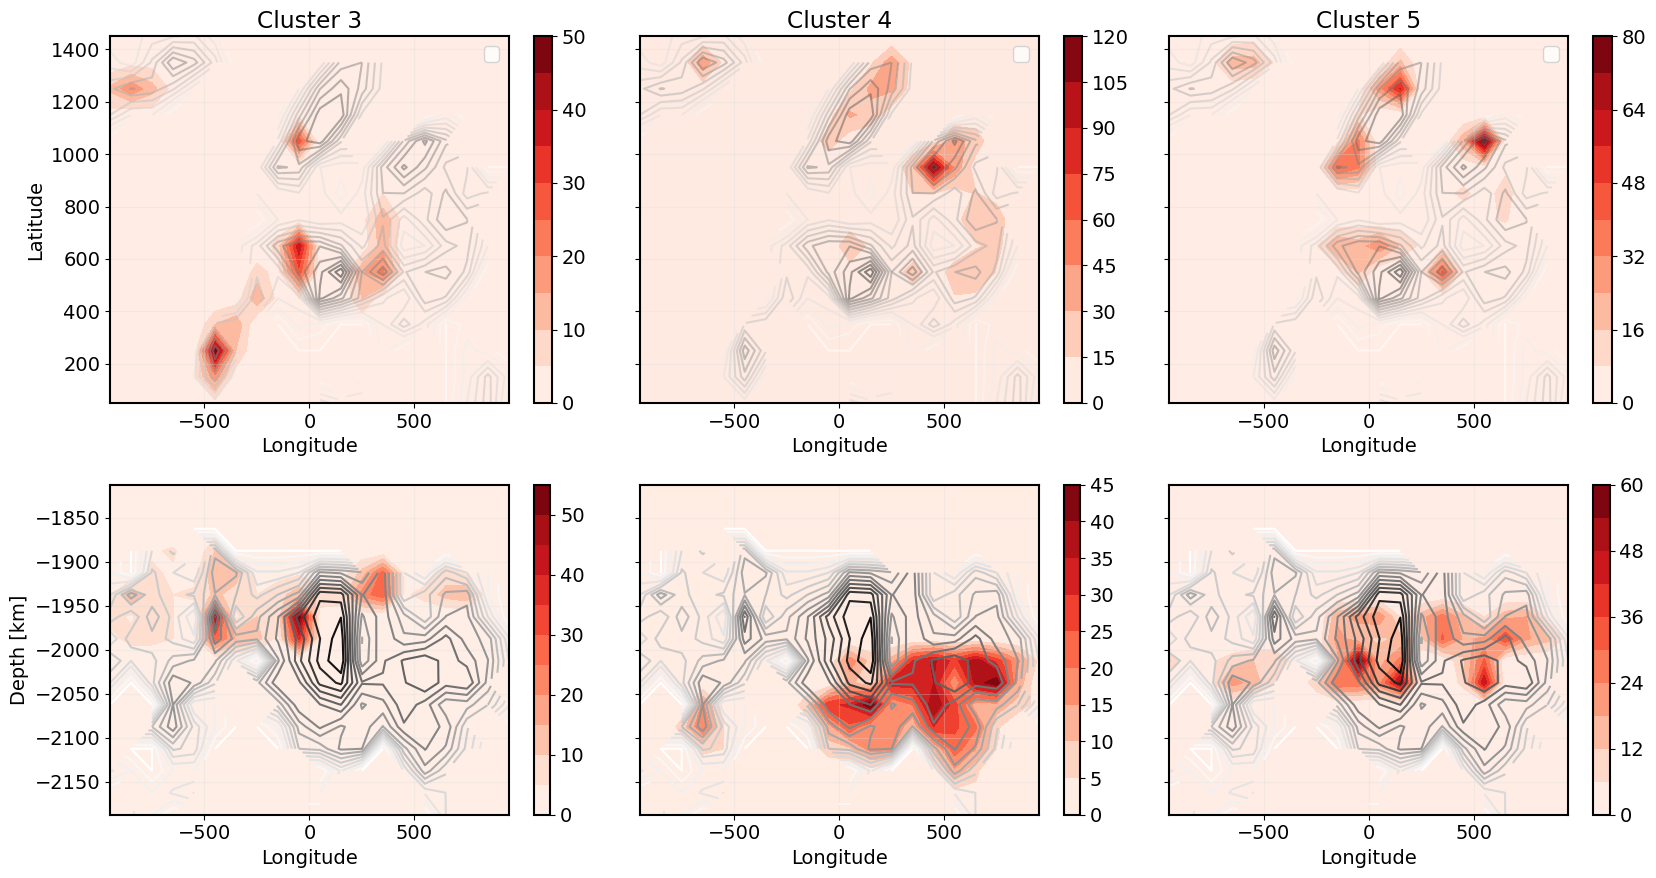

In [30]:
geo_bounds_plot = {'lat_min': -0,
            'lat_max': 1500,
            'long_min': -1000,
            'long_max': 1000,
            'depth_min': 1800,
            'depth_max': 2200,
            'step_l': 100,
            'step_d': 25}

plotting_geo.plot_cluster_nodes(df_catalogue=df_catalogue, df_density=data_catalogue.df_density, geo_bounds=geo_bounds_plot)

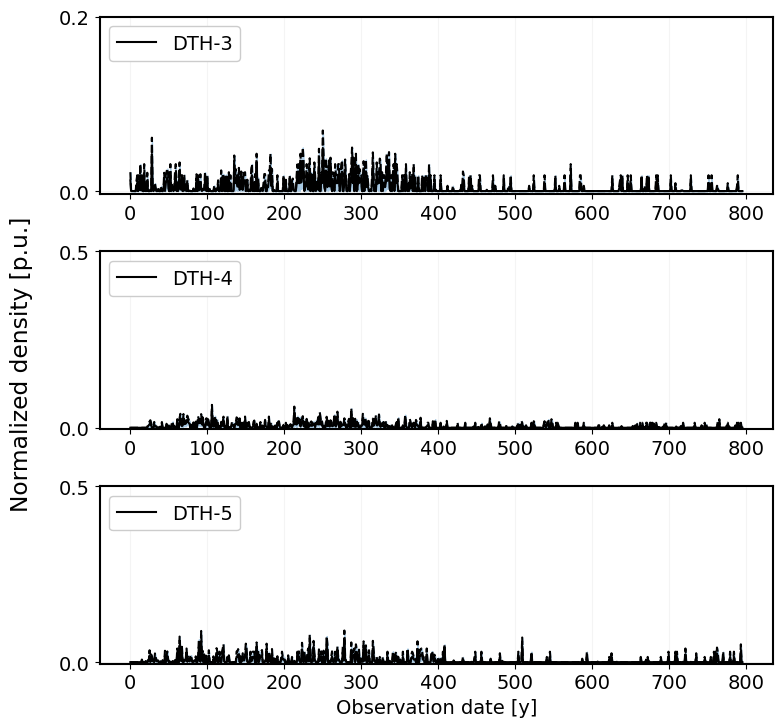

In [31]:
plotting_geo.plot_means_subplots(time_series_eq_nodes['72h'], cluster_label_test)

In [32]:
df_catalogue_time_sorted = df_catalogue.sort_values(by='event_time')
df_catalogue_time_sorted['IET'] = (df_catalogue_time_sorted.event_time - df_catalogue_time_sorted.event_time.shift(1))

In [33]:
df_catalogue_time_sorted['IET_seconds'] = df_catalogue_time_sorted.apply(lambda row: row['IET'].total_seconds(), axis = 1)
df_catalogue_time_sorted['IET_seconds_log10'] = np.log10(df_catalogue_time_sorted['IET_seconds'])
df_catalogue_time_sorted = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] > 0]

In [34]:
df_catalogue_time_sorted.dropna(subset='IET', inplace=True)

In [35]:
df_catalogue_time_sorted.head()

,event_time,Latitude,Longitude,Depth,magnitude,lat_id,long_id,depth_id,day_id,index_1D,cluster,IET,IET_seconds,IET_seconds_log10
NORSAR_ID,,,,,,,,,,,,,,
3,2011-12-17 16:10:01.009,443.789,-311.810,1907.743,-1.81,12,8,8,0,3708,3.0,2 days 15:12:40.263000,227560.263,5.357096
4,2012-01-09 18:41:47.932,481.279,-263.957,1939.138,-1.17,12,8,8,8,3708,3.0,23 days 02:31:46.923000,1996306.923,6.300227
5,2012-01-10 17:01:24.622,453.238,-268.834,1944.319,-1.23,12,8,8,8,3708,3.0,0 days 22:19:36.690000,80376.690,4.905130
6,2012-01-13 23:28:40.715,-732.434,-143.866,1844.954,-1.52,6,9,6,9,2841,3.0,3 days 06:27:16.093000,282436.093,5.450920
7,2012-01-18 08:59:57.938,-637.337,-176.479,1934.870,-0.71,6,9,8,11,3723,3.0,4 days 09:31:17.223000,379877.223,5.579643


In [36]:
df_catalogue_time_sorted.groupby('cluster')['IET_seconds'].agg(['mean', 'std'])

,mean,std
cluster,,
1.0,14596.757799,60019.385053
2.0,10668.505587,57502.247580
3.0,88409.258877,216439.792783
4.0,68954.371555,185455.196528
5.0,56309.179832,190005.567247


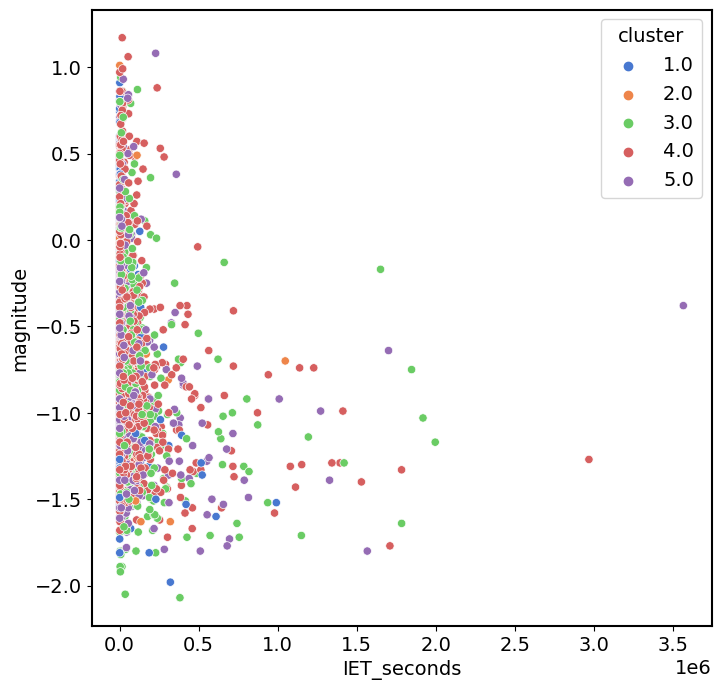

In [37]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'IET_seconds', y = 'magnitude', hue = 'cluster', palette='muted')
plt.show()

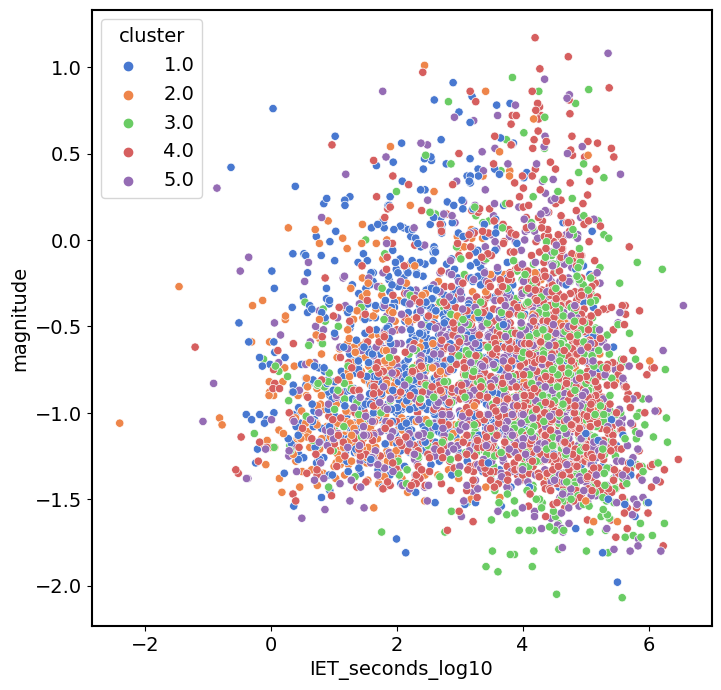

In [38]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'IET_seconds_log10', y = 'magnitude', hue = 'cluster', palette='muted')
plt.show()

In [39]:
def distance_from_inj(row):
    x = row['Longitude']
    y = row['Latitude']
    z = 2140 - row['Depth']

    distance = np.array([x, y, z])

    return np.sqrt(distance.dot(distance))


df_catalogue_time_sorted['dist_from_inj_m'] = df_catalogue.apply(lambda row: distance_from_inj(row), axis = 1)

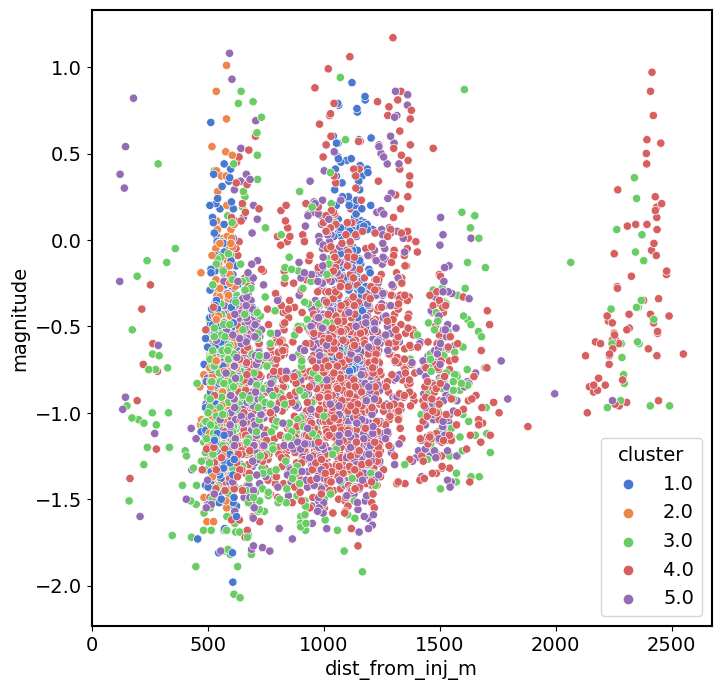

In [40]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'dist_from_inj_m', y = 'magnitude', hue = 'cluster', palette='muted')
plt.show()

In [41]:
event_time_start = df_catalogue_time_sorted['event_time'].min()

df_catalogue_time_sorted['event_time_seconds'] = df_catalogue_time_sorted.apply(lambda row: (row['event_time']-event_time_start).total_seconds(), axis = 1)

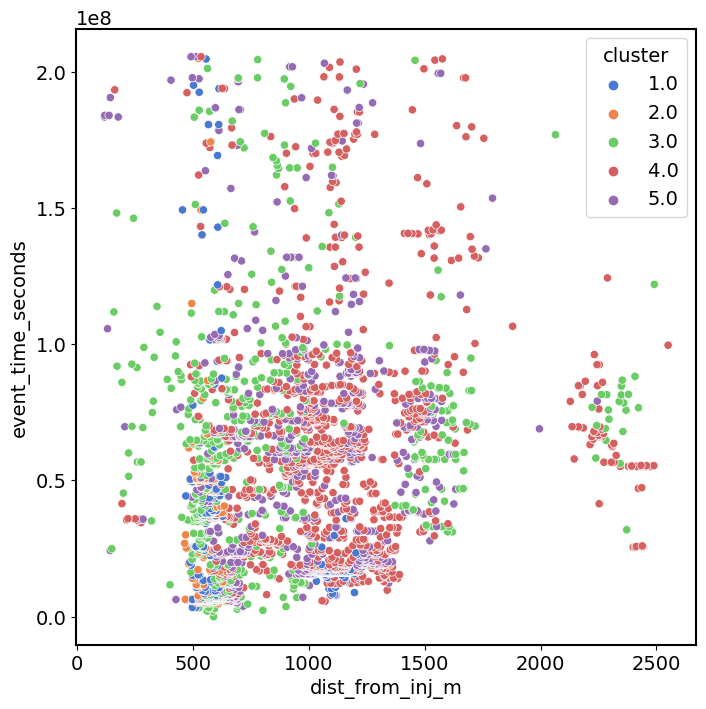

In [42]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'dist_from_inj_m', y = 'event_time_seconds', hue = 'cluster', palette='muted')
plt.show()

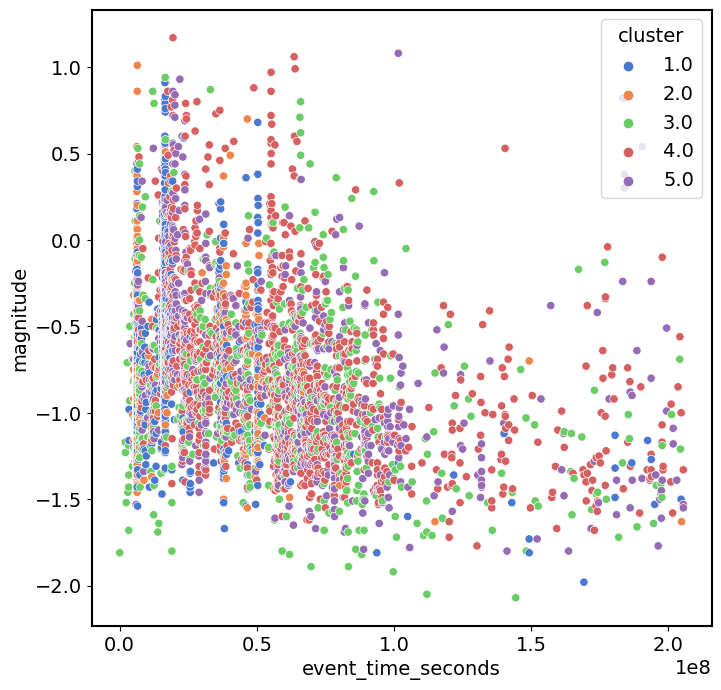

In [43]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'event_time_seconds', y = 'magnitude', hue = 'cluster', palette='muted')
plt.show()

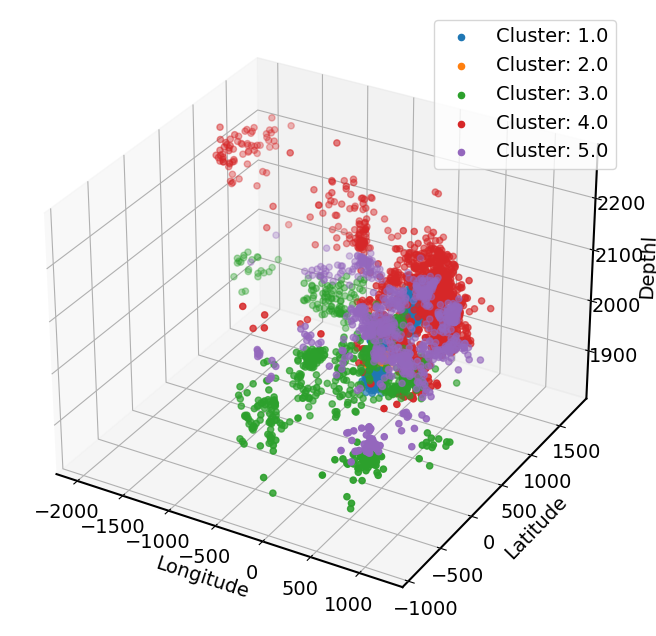

In [44]:
import matplotlib as mpl
mpl.interactive = True

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')



for cluster in np.sort(np.unique(df_catalogue_time_sorted['cluster'].values)):
    
    xs = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] == cluster]['Longitude'].values
    ys = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] == cluster]['Latitude'].values
    zs = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] == cluster]['Depth'].values
    ax.scatter(xs, ys, zs, label = f'Cluster: {cluster}')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depthl')
plt.legend()
plt.show()

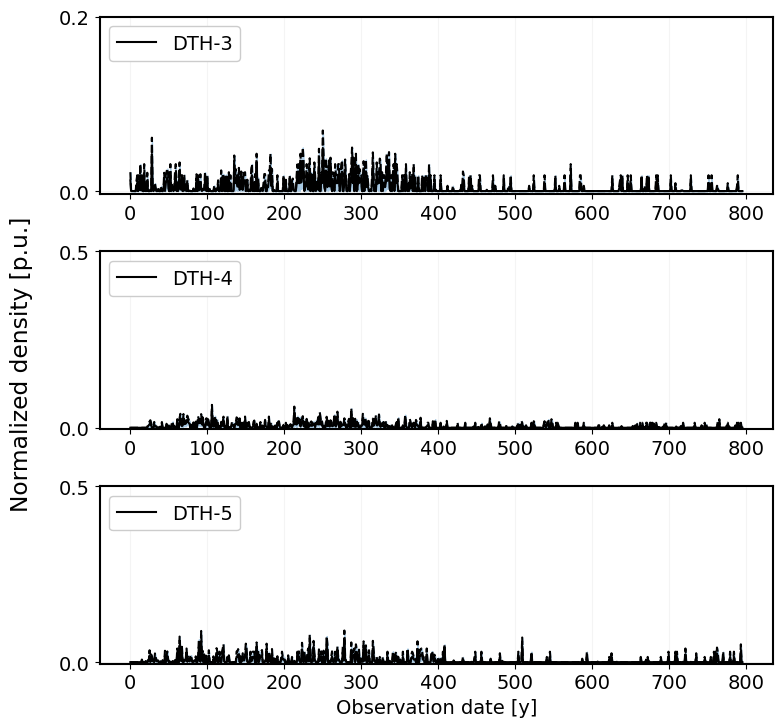

In [45]:
plotting_geo.plot_means_subplots(time_series_eq_nodes['72h'], cluster_label_test)